In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
import time

In [2]:
def create_circuit(n_qubits):
    
    dev = qml.device("lightning.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch")
    def circuit(params):
        
        for i in range(n_qubits):
            qml.RY(params[0, i]*np.pi, wires=i)
        for i in range(n_qubits):
            qml.IsingXX(params[1, i]*np.pi, wires=[i, (i+1)%n_qubits])
        measurements = []
        for i in range(n_qubits):
            measurements.append(qml.expval(qml.PauliZ(i)))
        return measurements

        return qml.expval(qml.PauliZ(0))
    
    return circuit

In [3]:
n_qubits = 5
circuit = create_circuit(n_qubits)

In [4]:
params = torch.rand((2, n_qubits), requires_grad=True)
print(params)


tensor([[0.5349, 0.9627, 0.7853, 0.0106, 0.0308],
        [0.2704, 0.2021, 0.9290, 0.7976, 0.7865]], requires_grad=True)


In [5]:
circuit(params)

[tensor(0.0572, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>),
 tensor(-0.2535, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>),
 tensor(0.6136, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>),
 tensor(0.7762, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>),
 tensor(0.6152, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>)]

/tmp/ipykernel_472935/4126486970.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


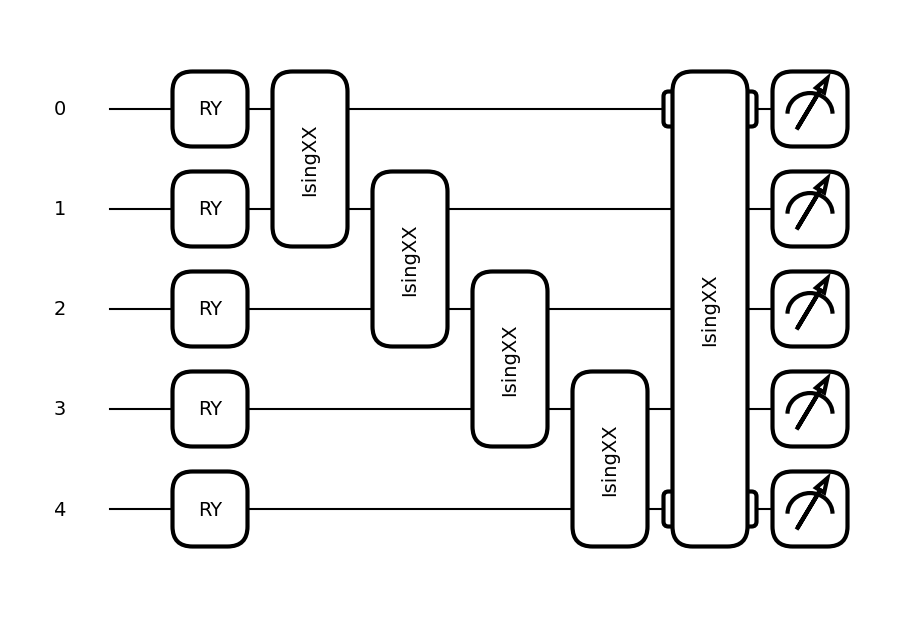

In [6]:
fig, ax = qml.draw_mpl(circuit)(params)
fig.show()

In [26]:
def cost(params):
    result = torch.stack(circuit(params)).type(torch.float32)
    # return sum([(1 - result[i])**2 for i in range(n_qubits)])
    return torch.nn.functional.mse_loss(result, torch.ones(len(result)), reduction="sum")
    

In [27]:
opt = torch.optim.Adam([params], lr = 0.1)

In [28]:
steps = 200

for i in range(steps):
    
    beg = time.time()
    opt.zero_grad()
    loss = cost(params)
    loss.backward()
    opt.step()
    end = time.time()
    print("loss:", loss.item(), "\t time:", np.round((end-beg)*1000, 1), "ms")

loss: 5.87419319152832 	 time: 44.6 ms
loss: 3.573259115219116 	 time: 30.2 ms
loss: 2.6968774795532227 	 time: 29.1 ms
loss: 2.444422483444214 	 time: 28.4 ms
loss: 2.525364875793457 	 time: 29.1 ms
loss: 2.4935879707336426 	 time: 28.3 ms
loss: 2.308622360229492 	 time: 28.1 ms
loss: 2.135775566101074 	 time: 29.0 ms
loss: 2.0328457355499268 	 time: 30.3 ms
loss: 1.9869179725646973 	 time: 30.9 ms
loss: 1.954182505607605 	 time: 29.0 ms
loss: 1.8604278564453125 	 time: 29.0 ms
loss: 1.6443607807159424 	 time: 28.1 ms
loss: 1.285256028175354 	 time: 26.7 ms
loss: 0.8223467469215393 	 time: 28.7 ms
loss: 0.3868786096572876 	 time: 29.9 ms
loss: 0.12309113889932632 	 time: 28.6 ms
loss: 0.03103305585682392 	 time: 27.9 ms
loss: 0.0183944683521986 	 time: 28.0 ms
loss: 0.05077467858791351 	 time: 27.8 ms
loss: 0.13282088935375214 	 time: 27.9 ms
loss: 0.22357600927352905 	 time: 27.4 ms
loss: 0.26451748609542847 	 time: 32.6 ms
loss: 0.24652111530303955 	 time: 29.8 ms
loss: 0.1994284689

In [10]:
beg = time.time()
time.sleep(1)
end = time.time()
end-beg

1.0003321170806885

## Real testing

In [2]:
steps = 200
file_name="pennylane.csv"

In [168]:
def test_time(n_qubits):
    circuit = create_circuit(n_qubits)
    params = torch.rand((2, n_qubits), requires_grad=True)
    def cost(params):
        return (1 - circuit(params))**2
    
    opt = torch.optim.Adam([params], lr = 0.1)
    beg_steps = 5
    for i in range(steps+beg_steps):
        if (i == beg_steps):
            beg = time.time()
        opt.zero_grad()
        loss = cost(params)
        loss.backward()
        opt.step()
    end = time.time()
    return (end-beg)*1000

In [173]:
from bench_func import run_benchmark

run_benchmark(range(2, 22), test_time, file_name)

  0%|          | 0/20 [00:00<?, ?it/s]

[2, 722.7649688720703]
[3, 1154.0467739105225]
[4, 1576.2629508972168]
[5, 2211.4205360412598]
[6, 2474.904775619507]
[7, 3374.466896057129]
[8, 4183.089971542358]
[9, 4995.209217071533]
[10, 6047.146320343018]
[11, 6764.789819717407]
[12, 8917.454719543457]
[13, 12870.530128479004]
[14, 15046.837091445923]
[15, 22922.544240951538]
[16, 34204.81038093567]
[17, 59179.59451675415]
[18, 106579.82730865479]
[19, 223136.61313056946]
[20, 1064649.9555110931]


KeyboardInterrupt: 

### standard simulator comparison

In [174]:
def create_circuit(n_qubits):
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch")
    def circuit(params):
        
        for i in range(n_qubits):
            qml.RY(params[0, i]*np.pi, wires=i)
        for i in range(n_qubits):
            qml.IsingXX(params[1, i]*np.pi, wires=[i, (i+1)%n_qubits])
        # measurements = []
        # for i in range(n_qubits):
        #     measurements.append(qml.expval(qml.PauliZ(i)))

        return qml.expval(qml.PauliZ(0))
    
    return circuit

In [175]:
steps = 200
file_name="pennylane_default.csv"

In [2]:
def test_time(n_qubits):
    circuit = create_circuit(n_qubits)
    params = torch.rand((2, n_qubits), requires_grad=True)
    def cost(params):
        return (1 - circuit(params))**2
    
    opt = torch.optim.Adam([params], lr = 0.1)
    beg_steps = 5
    for i in range(steps+beg_steps):
        if (i == beg_steps):
            beg = time.time()
        opt.zero_grad()
        loss = cost(params)
        loss.backward()
        opt.step()
    end = time.time()
    return (end-beg)*1000

In [177]:
from bench_func import run_benchmark

run_benchmark(range(2, 22), test_time, file_name)

  0%|          | 0/20 [00:00<?, ?it/s]

[2, 578.2110691070557]
[3, 795.2024936676025]
[4, 1035.4628562927246]
[5, 1295.1016426086426]
[6, 1539.4742488861084]
[7, 1986.0031604766846]
[8, 2621.9358444213867]
[9, 3195.876121520996]
[10, 3651.0398387908936]
[11, 3586.088180541992]
[12, 4023.5421657562256]
[13, 4638.354063034058]
[14, 5476.943492889404]
[15, 7176.120758056641]
[16, 9698.828220367432]
[17, 16247.95126914978]
[18, 36483.84618759155]
[19, 101134.68599319458]


qsim inside pennylane

In [1]:
def create_circuit(n_qubits):
    
    dev = qml.device("cirq.qsim", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch")
    def circuit(params):
        
        for i in range(n_qubits):
            qml.RY(params[0, i]*np.pi, wires=i)
        for i in range(n_qubits):
            qml.IsingXX(params[1, i]*np.pi, wires=[i, (i+1)%n_qubits])
        # measurements = []
        # for i in range(n_qubits):
        #     measurements.append(qml.expval(qml.PauliZ(i)))

        return qml.expval(qml.PauliZ(0))
    
    return circuit

In [3]:
steps = 200
file_name="pennylane_qsim.csv"

In [8]:
from bench_func import run_benchmark

run_benchmark(range(2, 22), test_time, file_name)

  0%|          | 0/20 [00:00<?, ?it/s]

[2, 2205.5821418762207]
[3, 3928.9917945861816]
[4, 5825.104236602783]
[5, 8853.173971176147]
[6, 11978.827714920044]
[7, 15020.973443984985]
[8, 20320.2965259552]
[9, 24027.501106262207]
[10, 30977.929830551147]
[11, 35051.639556884766]
[12, 42624.927282333374]
[13, 47516.804456710815]


KeyboardInterrupt: 

## Пытаюсь подкрутить параметры симулятора, чтобы он быстрее работал и задействовал все потоки.

In [1]:
# import os
# # os.environ["OMP_NUM_THREADS"] = "16"

import pennylane as qml
from pennylane import numpy as np
import torch
import time
i = 2

In [2]:
def create_circuit(n_qubits):
    
    dev = qml.device("lightning.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch", diff_method="adjoint")
    def circuit(params):
        
        for i in range(n_qubits):
            qml.RY(params[0, i]*np.pi, wires=i)
        for i in range(n_qubits):
            qml.IsingXX(params[1, i]*np.pi, wires=[i, (i+1)%n_qubits])
        # measurements = []
        # for i in range(n_qubits):
        #     measurements.append(qml.expval(qml.PauliZ(i)))

        return qml.expval(qml.PauliZ(0))
    
    return circuit

In [3]:
steps = 200
file_name=f"pennylane_lightning_adjoint_def_threads.csv"
i+=1

In [4]:
def test_time(n_qubits):
    circuit = create_circuit(n_qubits)
    params = torch.rand((2, n_qubits), requires_grad=True)
    def cost(params):
        return (1 - circuit(params))**2
    
    opt = torch.optim.Adam([params], lr = 0.1)
    beg_steps = 5
    for i in range(steps+beg_steps):
        if (i == beg_steps):
            beg = time.time()
        opt.zero_grad()
        loss = cost(params)
        loss.backward()
        opt.step()
    end = time.time()
    return (end-beg)*1000

In [5]:
from bench_func import run_benchmark

run_benchmark(range(2, 21), test_time, file_name)

  0%|          | 0/19 [00:00<?, ?it/s]

[2, 340.5570983886719]
[3, 412.23597526550293]
[4, 523.5011577606201]
[5, 572.1120834350586]
[6, 635.0505352020264]
[7, 737.5273704528809]
[8, 730.9644222259521]
[9, 895.9929943084717]
[10, 966.5517807006836]
[11, 997.2686767578125]
[12, 1161.623239517212]
[13, 1333.045482635498]
[14, 2058.168411254883]
[15, 2397.1030712127686]
[16, 4040.156126022339]
[17, 7633.999824523926]
[18, 23842.394590377808]
[19, 67102.06127166748]
[20, 167506.56056404114]


### Default simulator with adjoint method

In [6]:
def create_circuit(n_qubits):
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch", diff_method="adjoint")
    def circuit(params):
        
        for i in range(n_qubits):
            qml.RY(params[0, i]*np.pi, wires=i)
        for i in range(n_qubits):
            qml.IsingXX(params[1, i]*np.pi, wires=[i, (i+1)%n_qubits])
        # measurements = []
        # for i in range(n_qubits):
        #     measurements.append(qml.expval(qml.PauliZ(i)))

        return qml.expval(qml.PauliZ(0))
    
    return circuit

In [7]:
steps = 200
file_name=f"pennylane_default_adjoint.csv"
i+=1

In [8]:
def test_time(n_qubits):
    circuit = create_circuit(n_qubits)
    params = torch.rand((2, n_qubits), requires_grad=True)
    def cost(params):
        return (1 - circuit(params))**2
    
    opt = torch.optim.Adam([params], lr = 0.1)
    beg_steps = 5
    for i in range(steps+beg_steps):
        if (i == beg_steps):
            beg = time.time()
        opt.zero_grad()
        loss = cost(params)
        loss.backward()
        opt.step()
    end = time.time()
    return (end-beg)*1000

In [9]:
from bench_func import run_benchmark

run_benchmark(range(2, 21), test_time, file_name)

  0%|          | 0/19 [00:00<?, ?it/s]

[2, 1049.2565631866455]
[3, 1557.2338104248047]
[4, 1938.27223777771]
[5, 2367.347240447998]
[6, 2808.7501525878906]
[7, 3554.21781539917]
[8, 4738.585710525513]
[9, 5239.179849624634]
[10, 5933.870077133179]
[11, 6911.611795425415]
[12, 9016.988754272461]
[13, 10645.825147628784]
[14, 14416.558504104614]
[15, 22492.79761314392]
[16, 44232.14793205261]
[17, 82821.96974754333]
[18, 165205.8780193329]


KeyboardInterrupt: 

## Qsim adjoint inside pennylane

In [10]:
def create_circuit(n_qubits):
    
    dev = qml.device("cirq.qsim", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch", diff_method="adjoint")
    def circuit(params):
        
        for i in range(n_qubits):
            qml.RY(params[0, i]*np.pi, wires=i)
        for i in range(n_qubits):
            qml.IsingXX(params[1, i]*np.pi, wires=[i, (i+1)%n_qubits])
        # measurements = []
        # for i in range(n_qubits):
        #     measurements.append(qml.expval(qml.PauliZ(i)))

        return qml.expval(qml.PauliZ(0))
    
    return circuit

In [11]:
steps = 200
file_name=f"pennylane_qsim_adjoint.csv"
i+=1

In [12]:
def test_time(n_qubits):
    circuit = create_circuit(n_qubits)
    params = torch.rand((2, n_qubits), requires_grad=True)
    def cost(params):
        return (1 - circuit(params))**2
    
    opt = torch.optim.Adam([params], lr = 0.1)
    beg_steps = 5
    for i in range(steps+beg_steps):
        if (i == beg_steps):
            beg = time.time()
        opt.zero_grad()
        loss = cost(params)
        loss.backward()
        opt.step()
    end = time.time()
    return (end-beg)*1000

In [13]:
from bench_func import run_benchmark

run_benchmark(range(2, 21), test_time, file_name)

  0%|          | 0/19 [00:00<?, ?it/s]

ValueError: The cirq.qsim device does not support adjoint differentiation.